In [1]:
# Creating a Deep Convolutional Generative Adverserial Network that creates realistic Face Images.
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
from PIL import Image
import numpy as np

import torch
from torch import nn

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
img_size = 64
img_channels = 1
# Transform the images to 64x64
transformations = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=img_channels),
        transforms.ToTensor(),
    ]
)

In [5]:
# Visualize a data sample
image_path = "datasets/Face Dataset/s1/1.pgm"
image = Image.open(image_path)  # Load as PIL Image
image = transformations(image)  # Convert to tensor

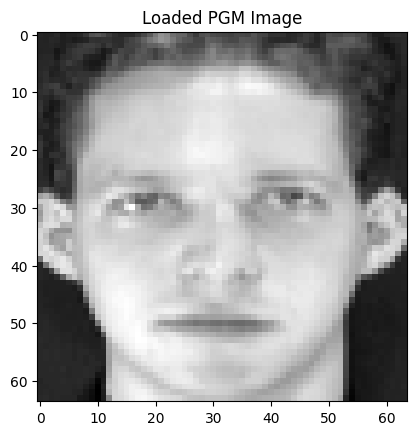

In [6]:
# Display the image
plt.imshow(image.squeeze(), cmap="gray")
plt.title("Loaded PGM Image")
plt.show()

In [7]:
# Load the entire dataset
data_dir = "datasets/Face Dataset"
dataset = ImageFolder(root=data_dir, transform=transformations)
print(len(dataset))
print(f"Number of classes: {len(dataset.classes)}")

400
Number of classes: 40


In [8]:
# Create the Dataloader
BATCH_SIZE = 16

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
data_iter = iter(dataloader)
first_batch_samples, first_batch_labels = next(data_iter)
first_batch_samples.shape, first_batch_labels.shape

(torch.Size([16, 1, 64, 64]), torch.Size([16]))

In [10]:
# Creating the DC-GAN
# Creating the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)

In [11]:
# Creating the Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [12]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [13]:
# Testing the output shapes of the Discriminator and the Generator
def test():
    N, in_channels, H, W = 8, 1, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)

    print(disc(x).shape)
    assert disc(x).shape == (N, 1, 1, 1)

    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))

    print(gen(z).shape)
    assert(gen(z).shape) == (N, in_channels, H, W)

In [14]:
test()

torch.Size([8, 1, 1, 1])
torch.Size([8, 1, 64, 64])


In [15]:
# Setup the hyperparameters
learning_rate = 2e-4
batch_size = 16
image_size = 64
img_channels = 1
z_dim = 100
epochs = 200
features_disc = 64
features_gen = 64

In [16]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [17]:
initialize_weights(gen)
initialize_weights(disc)

In [18]:
# Create the optimizer and the loss function
opt_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

In [19]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

In [20]:
# Set the models to training mode
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [ ]:
fake_images = []

for epoch in range(epochs):
    for batch_index, (real_images, labels) in enumerate(dataloader):
        real_images = real_images.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)
        
        # Train the discriminator max log(D(X)) + log(1 - (D(G(X))))
        disc_real = disc(real_images).reshape(-1) # Flatten the output
        loss_disc_real = loss_function(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = loss_function(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        # Train the Generator max log(D(G(z)))
        output = disc(fake).reshape(-1)
        loss_gen = loss_function(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_index % 5 == 0:
            print(f'Epoch: {epoch}. Batches seen: {batch_index}.')
            fake_images.append(fake)

Epoch: 0. Batches seen: 0.
Epoch: 0. Batches seen: 5.
Epoch: 0. Batches seen: 10.
Epoch: 0. Batches seen: 15.
Epoch: 0. Batches seen: 20.
Epoch: 1. Batches seen: 0.
Epoch: 1. Batches seen: 5.
Epoch: 1. Batches seen: 10.
Epoch: 1. Batches seen: 15.
Epoch: 1. Batches seen: 20.
Epoch: 2. Batches seen: 0.
Epoch: 2. Batches seen: 5.
Epoch: 2. Batches seen: 10.
Epoch: 2. Batches seen: 15.
Epoch: 2. Batches seen: 20.
Epoch: 3. Batches seen: 0.
Epoch: 3. Batches seen: 5.
Epoch: 3. Batches seen: 10.
Epoch: 3. Batches seen: 15.
Epoch: 3. Batches seen: 20.
Epoch: 4. Batches seen: 0.
Epoch: 4. Batches seen: 5.
Epoch: 4. Batches seen: 10.
Epoch: 4. Batches seen: 15.
Epoch: 4. Batches seen: 20.
Epoch: 5. Batches seen: 0.
Epoch: 5. Batches seen: 5.
Epoch: 5. Batches seen: 10.
Epoch: 5. Batches seen: 15.
Epoch: 5. Batches seen: 20.
Epoch: 6. Batches seen: 0.
Epoch: 6. Batches seen: 5.
Epoch: 6. Batches seen: 10.
Epoch: 6. Batches seen: 15.
Epoch: 6. Batches seen: 20.
Epoch: 7. Batches seen: 0.
Epoch: 

In [ ]:
fake_image = fake_images[-1]
fake_image[10][0].shape

In [ ]:
print('Fake Generated Images:')

for i in range(1, 16):
    grid = plt.subplot(4, 4, i)
    plt.axis(False)
    plt.imshow(fake_image[i][0].squeeze(dim=0).cpu().detach().numpy(), cmap='gray')

